In [82]:
# Import necessary libraries
import torch
import matplotlib.pyplot as plt
from torch import nn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os


In [83]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [84]:
# Create the data parameters

n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

# Make X and y using linear regression feature
weight = 0.3
bias = 0.9

# Create data
start = 0
end = 1
step = 0.01
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

print(f"Number of X samples: {len(X)}")
print(f"Number of y samples: {len(y)}")
print(f"First 10 X & y samples:\nX: {X[:10]}\ny: {y[:10]}")

Number of X samples: 100
Number of y samples: 100
First 10 X & y samples:
X: tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]])
y: tensor([[0.9000],
        [0.9030],
        [0.9060],
        [0.9090],
        [0.9120],
        [0.9150],
        [0.9180],
        [0.9210],
        [0.9240],
        [0.9270]])


In [85]:
# Split the data into training and testing
train_split = int(0.80 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

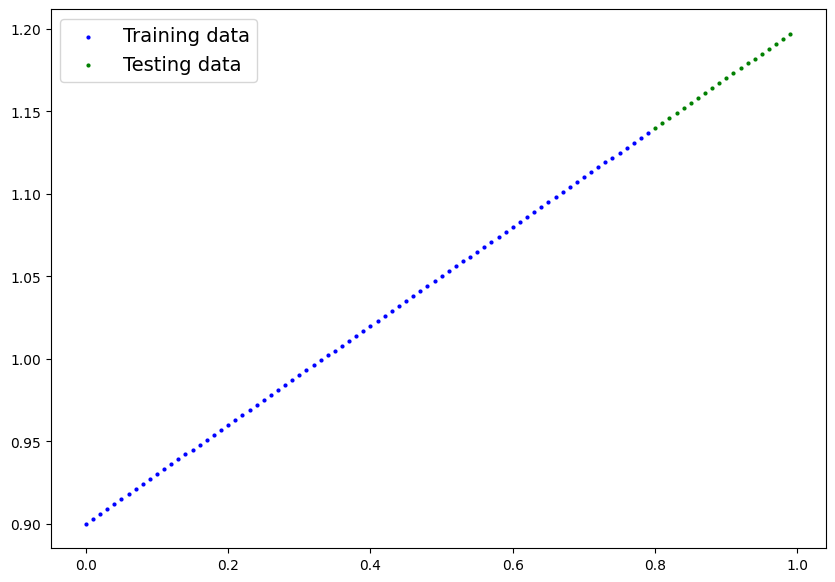

In [86]:
# Plot the training and testing data
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});
plot_predictions();

In [87]:
# Create PyTorch linear regression model by subclassing nn.Module
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias

In [88]:
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [89]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always needed but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [90]:
# Instantiate the model and put it to the target device
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [91]:
# Create the loss function and optimizer
loss_fn = nn.L1Loss()

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [92]:
torch.manual_seed(42)

# Training loop

train_loss_values = []
test_loss_values = []
epoch_count = []
# Train model for 300 epochs
epochs = 300


# Send data to target device


for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

  ### Perform testing every 20 epochs
      if epoch % 20 == 0:
    # Put model in evaluation mode and setup inference context
      # 1. Forward pass
            epoch_count.append(epoch)
      # 2. Calculate test loss
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
      # Print out what's happening
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")







Epoch: 0 | MAE Train Loss: 0.7566978335380554 | MAE Test Loss: 0.7248174548149109 
Epoch: 20 | MAE Train Loss: 0.5254928469657898 | MAE Test Loss: 0.4541124403476715 
Epoch: 40 | MAE Train Loss: 0.2942880392074585 | MAE Test Loss: 0.18340764939785004 
Epoch: 60 | MAE Train Loss: 0.07658576965332031 | MAE Test Loss: 0.07274086028337479 
Epoch: 80 | MAE Train Loss: 0.05255373567342758 | MAE Test Loss: 0.11581540107727051 
Epoch: 100 | MAE Train Loss: 0.045542728155851364 | MAE Test Loss: 0.10467890650033951 
Epoch: 120 | MAE Train Loss: 0.03868866711854935 | MAE Test Loss: 0.08938358724117279 
Epoch: 140 | MAE Train Loss: 0.03183453157544136 | MAE Test Loss: 0.07408786565065384 
Epoch: 160 | MAE Train Loss: 0.024982359260320663 | MAE Test Loss: 0.0581042543053627 
Epoch: 180 | MAE Train Loss: 0.018130185082554817 | MAE Test Loss: 0.04212062805891037 
Epoch: 200 | MAE Train Loss: 0.011278990656137466 | MAE Test Loss: 0.02579306997358799 
Epoch: 220 | MAE Train Loss: 0.004429381340742111 |

In [93]:
# Make predictions with the model

model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():

  y_preds = model_0(X_test)
y_preds

tensor([[1.1464],
        [1.1495],
        [1.1525],
        [1.1556],
        [1.1587],
        [1.1617],
        [1.1648],
        [1.1679],
        [1.1709],
        [1.1740],
        [1.1771],
        [1.1801],
        [1.1832],
        [1.1863],
        [1.1893],
        [1.1924],
        [1.1955],
        [1.1985],
        [1.2016],
        [1.2047]])

In [94]:
next(model_1.parameters()).device

device(type='cpu')

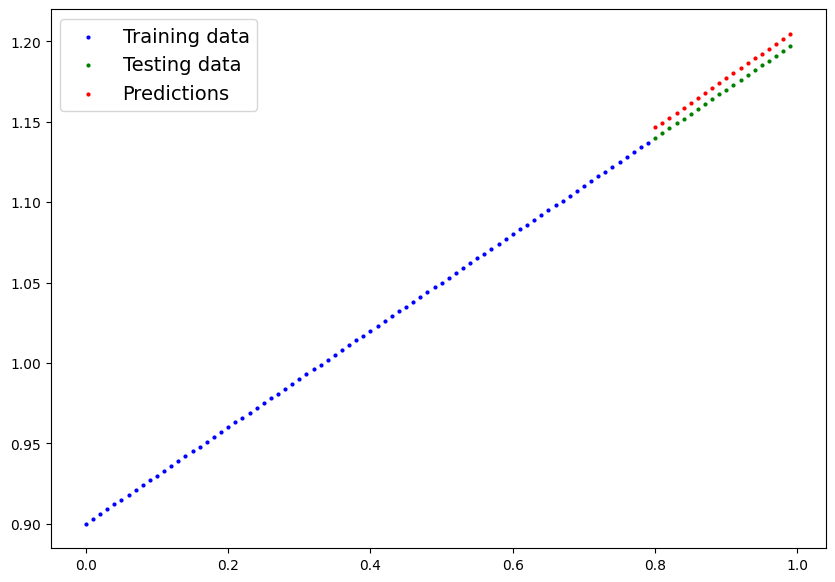

In [95]:
# Plot the predictions (these may need to be on a specific device)
plot_predictions(predictions=y_preds)

In [96]:
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 2117 Oct 31 07:28 models/01_pytorch_workflow_model_0.pth


In [97]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [98]:
# Create new instance of model and load saved state dict (make sure to put it on the target devloaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [99]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

In [101]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [102]:
# Make predictions with loaded model and compare them to the previous
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])